# Scatterplot Louvain

In [2]:
from pandas                 import DataFrame as df
from databaseconnection     import DatabaseConnection
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt

gds = DatabaseConnection().get_database_connection()
gds.version()


'2.3.2'

In [3]:
respondents = gds.run_cypher("MATCH (r:Respondent) RETURN r")["r"]

# Convert the respondents Series to a DataFrame
respondents_data = []
for respondent in respondents:
    respondents_data.append({'id': respondent['id'], 'normalityIndex': respondent["normalityIndex"], 'louvainCommunity': respondent["louvainCommunity"]})

respondents_df = df(respondents_data)

## Scatterplot of the respondents.

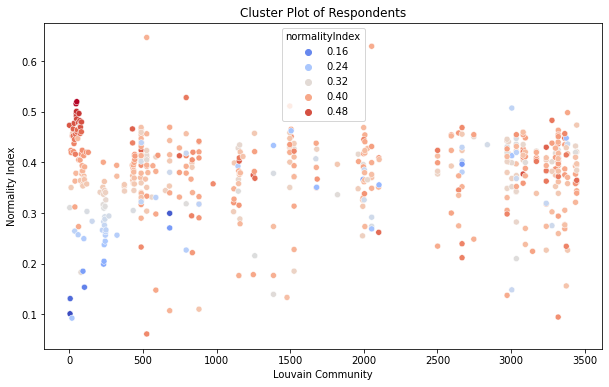

In [4]:
# Calculate the mean normalityIndex for each Louvain community
mean_normality_index = respondents_df.groupby('louvainCommunity')['normalityIndex'].mean()

# Add a new column to the DataFrame with the mean normalityIndex for each Louvain community
respondents_df['mean_normalityIndex'] = respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x])

# Create the cluster plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=respondents_df, x="louvainCommunity", y="normalityIndex", hue=mean_normality_index, palette='coolwarm')
plt.xlabel("Louvain Community")
plt.ylabel("Normality Index")
plt.title("Cluster Plot of Respondents")
plt.show()

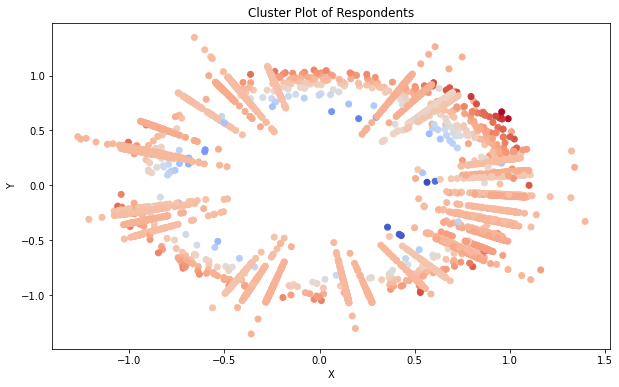

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Calculate the mean normalityIndex for each Louvain community
mean_normality_index = respondents_df.groupby('louvainCommunity')['normalityIndex'].mean()

# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(0.5, 1.5))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Convert Louvain community and normalized normality index to 2D Cartesian coordinates
unique_communities = respondents_df['louvainCommunity'].nunique()
respondents_df['theta'] = respondents_df['louvainCommunity'].apply(lambda x: 2 * np.pi * x / unique_communities)
respondents_df['x'] = respondents_df['normalized_normalityIndex'] * np.cos(respondents_df['theta'])
respondents_df['y'] = respondents_df['normalized_normalityIndex'] * np.sin(respondents_df['theta'])

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.show()

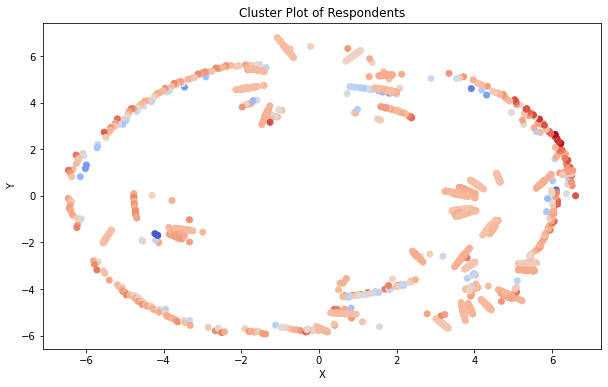

In [6]:
# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(1, 2))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Generate unique centroid coordinates for each Louvain community
unique_communities = respondents_df['louvainCommunity'].nunique()
theta = np.linspace(0, 2 * np.pi, unique_communities + 1)[:-1]  # Exclude the last value to prevent overlapping of the first and last centroids
centroid_radius = 5  # You can adjust this value to control the distance between the centroids and the origin
centroids = {community: (centroid_radius * np.cos(angle), centroid_radius * np.sin(angle)) for community, angle in zip(sorted(respondents_df['louvainCommunity'].unique()), theta)}

# Calculate the distance from the centroid for each respondent based on their normality index
respondents_df['x'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][0] + row['normalized_normalityIndex'] * np.cos(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)
respondents_df['y'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][1] + row['normalized_normalityIndex'] * np.sin(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.show()

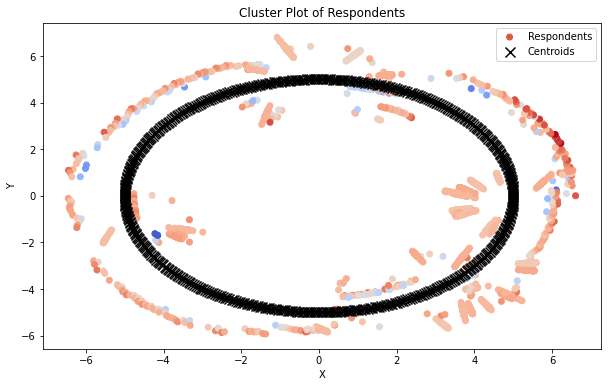

In [7]:
# Normalize the normalityIndex values to a suitable range
scaler = MinMaxScaler(feature_range=(1, 2))
respondents_df['normalized_normalityIndex'] = scaler.fit_transform(respondents_df[['normalityIndex']])

# Generate unique centroid coordinates for each Louvain community
unique_communities = respondents_df['louvainCommunity'].nunique()
theta = np.linspace(0, 2 * np.pi, unique_communities + 1)[:-1]
centroid_radius = 5
centroids = {community: (centroid_radius * np.cos(angle), centroid_radius * np.sin(angle)) for community, angle in zip(sorted(respondents_df['louvainCommunity'].unique()), theta)}

# Calculate the distance from the centroid for each respondent based on their normality index
respondents_df['x'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][0] + row['normalized_normalityIndex'] * np.cos(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)
respondents_df['y'] = respondents_df.apply(lambda row: centroids[row['louvainCommunity']][1] + row['normalized_normalityIndex'] * np.sin(row['louvainCommunity'] * 2 * np.pi / unique_communities), axis=1)

# Create the cluster plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(respondents_df['x'], respondents_df['y'], c=respondents_df['louvainCommunity'].apply(lambda x: mean_normality_index[x]), cmap='coolwarm', label='Respondents')
centroid_x, centroid_y = zip(*centroids.values())
plt.scatter(centroid_x, centroid_y, c='black', marker='x', s=100, label='Centroids')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Cluster Plot of Respondents")
plt.legend()
plt.show()

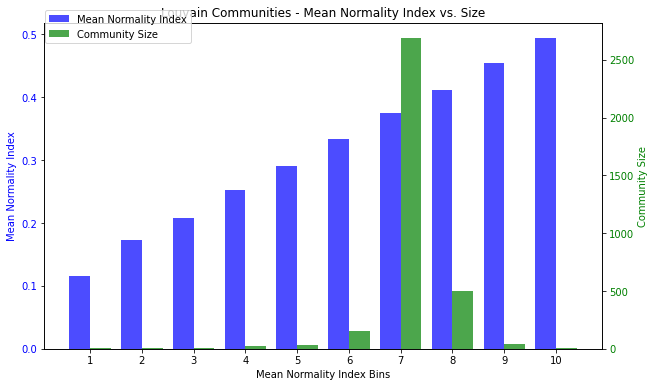

In [8]:
# Group by louvainCommunity and calculate mean, standard deviation, and size
community_stats = respondents_df.groupby('louvainCommunity').agg({'normalityIndex': ['mean', 'std', 'count']}).reset_index()
community_stats.columns = ['louvainCommunity', 'mean_normalityIndex', 'std_normalityIndex', 'size']

# Categorize Louvain communities into bins based on mean_normalityIndex
num_bins = 10  # You can adjust this value to control the number of bins
community_stats['mean_normalityIndex_bin'] = pd.cut(community_stats['mean_normalityIndex'], bins=num_bins, labels=np.arange(1, num_bins + 1))

# Calculate the aggregated size and mean_normalityIndex for each bin
binned_stats = community_stats.groupby('mean_normalityIndex_bin').agg({'size': 'sum', 'mean_normalityIndex': 'mean'}).reset_index()

# Create a grouped bar chart with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

width = 0.4
x = np.arange(len(binned_stats))

ax1.bar(x - width / 2, binned_stats['mean_normalityIndex'], width, label='Mean Normality Index', color='blue', alpha=0.7)
ax2.bar(x + width / 2, binned_stats['size'], width, label='Community Size', color='green', alpha=0.7)

ax1.set_xlabel('Mean Normality Index Bins')
ax1.set_ylabel('Mean Normality Index', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.set_ylabel('Community Size', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax1.set_xticks(x)
ax1.set_xticklabels(binned_stats['mean_normalityIndex_bin'])

plt.title("Louvain Communities - Mean Normality Index vs. Size")
fig.legend(loc="upper left", bbox_to_anchor=(0.12, 0.92))
plt.show()

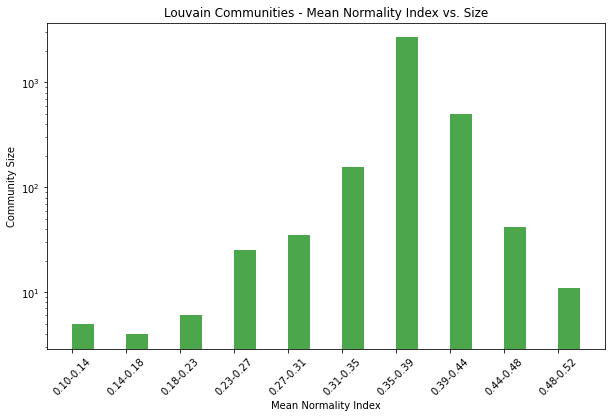

In [9]:
# Group by louvainCommunity and calculate mean, standard deviation, and size
community_stats = respondents_df.groupby('louvainCommunity').agg({'normalityIndex': ['mean', 'std', 'count']}).reset_index()
community_stats.columns = ['louvainCommunity', 'mean_normalityIndex', 'std_normalityIndex', 'size']

# Categorize Louvain communities into bins based on mean_normalityIndex
num_bins = 10  # You can adjust this value to control the number of bins
community_stats['mean_normalityIndex_bin'], bin_intervals = pd.cut(community_stats['mean_normalityIndex'], bins=num_bins, labels=False, retbins=True)
community_stats['mean_normalityIndex_bin'] += 1

# Calculate the aggregated size and mean_normalityIndex for each bin
binned_stats = community_stats.groupby('mean_normalityIndex_bin').agg({'size': 'sum', 'mean_normalityIndex': 'mean'}).reset_index()

# Create a grouped bar chart with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

width = 0.4
x = np.arange(len(binned_stats))

ax1.bar(x + width / 2, binned_stats['size'], width, label='Community Size', color='green', alpha=0.7)

ax1.set_xlabel('Mean Normality Index')
ax1.set_ylabel('Community Size')
ax1.tick_params(axis='y')

bin_labels = [f"{bin_intervals[i]:.2f}-{bin_intervals[i + 1]:.2f}" for i in range(num_bins)]
ax1.set_xticks(x)
ax1.set_xticklabels(bin_labels, rotation=45)

ax1.set_yscale('log')

plt.title("Louvain Communities - Mean Normality Index vs. Size")
plt.show()

## Making all small clusters into a unified outlier cluster.

According to Friends, about 10% of students are subjected to bullyism. Our thesis is that the many small outlier clusters that we have are actually students who are bullied. We will therefore make a new cluster for all the small clusters which will be the outliers.

If this clusters turns out to be about 10% of the students, then we have an indication that our thesis is correct.


Potentially bullied respondents/all repondents: 14.42%


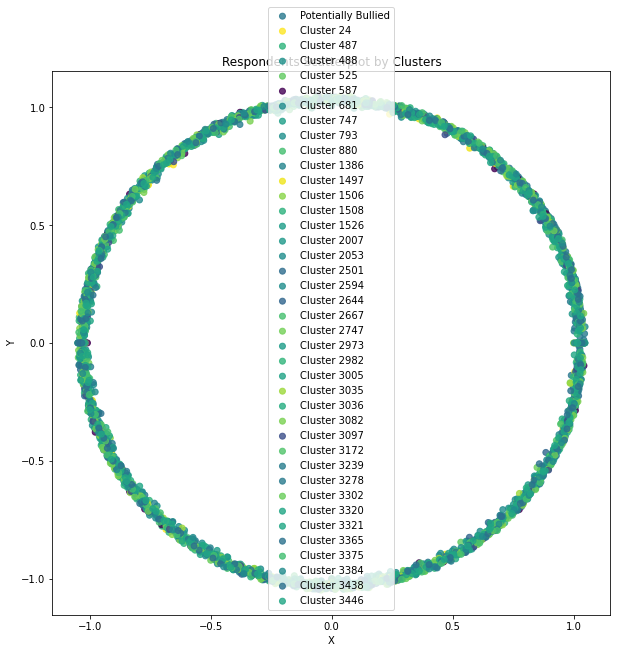

In [10]:

# Create a new cluster for small clusters
respondents_df['cluster'] = respondents_df['louvainCommunity']
small_clusters = respondents_df['louvainCommunity'].value_counts().loc[lambda x: x <= 10].index
respondents_df.loc[respondents_df['louvainCommunity'].isin(small_clusters), 'cluster'] = -1

# Calculate the mean normality index for each cluster
cluster_means = respondents_df.groupby('cluster')['normalityIndex'].mean()

# Assign colors to clusters based on their mean normality index
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(cluster_means.min(), cluster_means.max())
colors = {cluster: cmap(norm(mean)) for cluster, mean in cluster_means.items()}

# Function to generate non-overlapping circular layouts
def create_circular_layout(df, cluster_col, angle_col, radius_col, base_radius=1, min_radius=0.05):
    layout_df = df.copy()
    layout_df[angle_col] = 0
    layout_df[radius_col] = 0
    clusters = layout_df[cluster_col].unique()

    for cluster in clusters:
        cluster_data = layout_df[layout_df[cluster_col] == cluster]
        n = len(cluster_data)
        angles = np.linspace(0, 2 * np.pi, n + 1)[:-1]
        radii = base_radius + (cluster_data['normalityIndex'] - cluster_data['normalityIndex'].min()) * min_radius / (cluster_data['normalityIndex'].max() - cluster_data['normalityIndex'].min())
        layout_df.loc[cluster_data.index, angle_col] = angles
        layout_df.loc[cluster_data.index, radius_col] = radii

    return layout_df

# Create a non-overlapping circular layout
layout_df = create_circular_layout(respondents_df, 'cluster', 'angle', 'radius')

# Convert polar coordinates to Cartesian coordinates
layout_df['x'] = layout_df['radius'] * np.cos(layout_df['angle'])
layout_df['y'] = layout_df['radius'] * np.sin(layout_df['angle'])

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))
for cluster, group in layout_df.groupby('cluster'):
    label = "Potentially Bullied" if cluster == -1 else f"Cluster {cluster}"
    ax.scatter(group['x'], group['y'], c=group['cluster'].map(colors), label=label, alpha=0.8)
print(f"Potentially bullied respondents/all repondents: {len(layout_df[layout_df['cluster'] == -1]) / len(layout_df):.2%}")
ax.legend()
ax.set_title("Respondents Scatterplot by Clusters")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


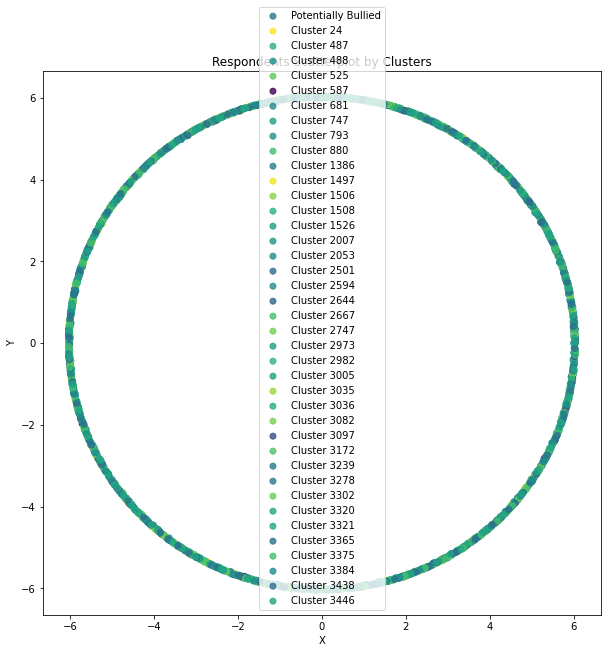

In [11]:

# Create a new cluster for small clusters
respondents_df['cluster'] = respondents_df['louvainCommunity']
small_clusters = respondents_df['louvainCommunity'].value_counts().loc[lambda x: x <= 10].index
respondents_df.loc[respondents_df['louvainCommunity'].isin(small_clusters), 'cluster'] = -1

# Calculate the mean normality index for each cluster
cluster_means = respondents_df.groupby('cluster')['normalityIndex'].mean()

# Assign colors to clusters based on their mean normality index
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(cluster_means.min(), cluster_means.max())
colors = {cluster: cmap(norm(mean)) for cluster, mean in cluster_means.items()}

# Function to generate non-overlapping circular layouts
def create_circular_layout(df, cluster_col, angle_col, radius_col, base_radius=1, min_radius=0.05, cluster_radius=5):
    layout_df = df.copy()
    layout_df[angle_col] = 0
    layout_df[radius_col] = 0
    clusters = layout_df[cluster_col].unique()

    cluster_angles = np.linspace(0, 2 * np.pi, len(clusters) + 1)[:-1]

    for idx, cluster in enumerate(clusters):
        cluster_data = layout_df[layout_df[cluster_col] == cluster]
        n = len(cluster_data)
        angles = np.linspace(0, 2 * np.pi, n + 1)[:-1]
        radii = base_radius + (cluster_data['normalityIndex'] - cluster_data['normalityIndex'].min()) * min_radius / (cluster_data['normalityIndex'].max() - cluster_data['normalityIndex'].min())
        layout_df.loc[cluster_data.index, angle_col] = angles + cluster_angles[idx]
        layout_df.loc[cluster_data.index, radius_col] = radii + cluster_radius

    return layout_df

# Create a non-overlapping circular layout
layout_df = create_circular_layout(respondents_df, 'cluster', 'angle', 'radius')

# Convert polar coordinates to Cartesian coordinates
layout_df['x'] = layout_df['radius'] * np.cos(layout_df['angle'])
layout_df['y'] = layout_df['radius'] * np.sin(layout_df['angle'])

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))
for cluster, group in layout_df.groupby('cluster'):
    label = "Potentially Bullied" if cluster == -1 else f"Cluster {cluster}"
    ax.scatter(group['x'], group['y'], c=group['cluster'].map(colors), label=label, alpha=0.8)

ax.legend()
ax.set_title("Respondents Scatterplot by Clusters")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


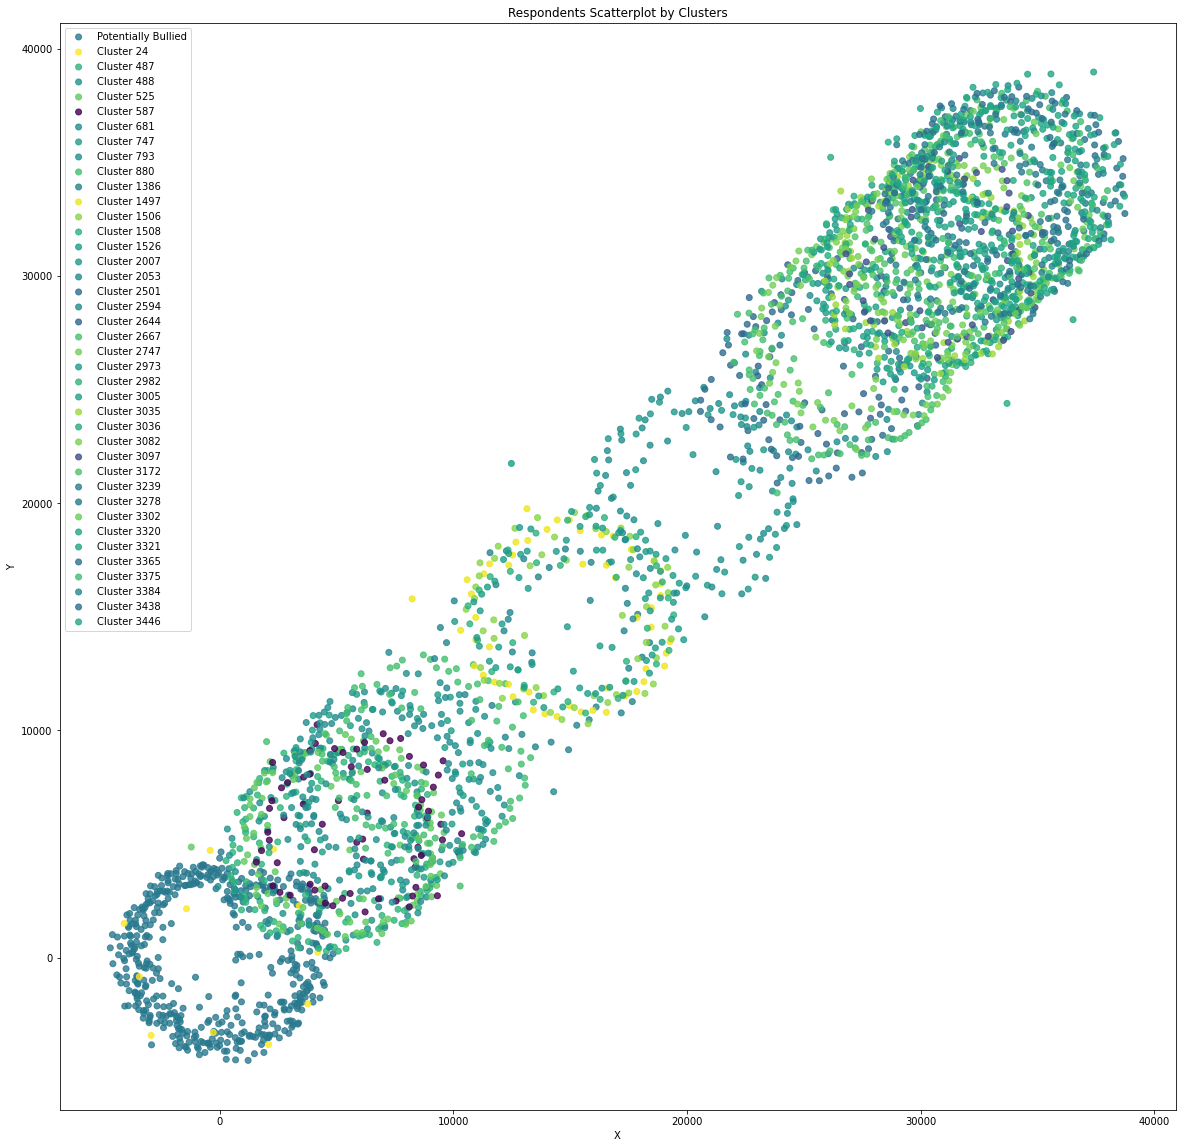

In [12]:

# Create a new cluster for small clusters
respondents_df['cluster'] = respondents_df['louvainCommunity']
small_clusters = respondents_df['louvainCommunity'].value_counts().loc[lambda x: x <= 10].index
respondents_df.loc[respondents_df['louvainCommunity'].isin(small_clusters), 'cluster'] = -1

# Calculate the mean normality index for each cluster
cluster_means = respondents_df.groupby('cluster')['normalityIndex'].mean()

# Assign colors to clusters based on their mean normality index
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(cluster_means.min(), cluster_means.max())
colors = {cluster: cmap(norm(mean)) for cluster, mean in cluster_means.items()}

# Function to generate a layout with unique centroids
def create_layout(df, cluster_col, x_col, y_col):
    layout_df = df.copy()
    layout_df[x_col] = 0
    layout_df[y_col] = 0
    clusters = layout_df[cluster_col].unique()

    for cluster in clusters:
        cluster_data = layout_df[layout_df[cluster_col] == cluster]
        n = len(cluster_data)
        angles = np.linspace(0, 2 * np.pi, n + 1)[:-1]
        radii = cluster_data['normalityIndex'] * 10000
        layout_df.loc[cluster_data.index, x_col] = cluster * 10 + radii * np.cos(angles)
        layout_df.loc[cluster_data.index, y_col] = cluster * 10 + radii * np.sin(angles)

    return layout_df

# Create a layout with unique centroids
layout_df = create_layout(respondents_df, 'cluster', 'x', 'y')

# Plot the clusters
fig, ax = plt.subplots(figsize=(20, 20))
for cluster, group in layout_df.groupby('cluster'):
    label = "Potentially Bullied" if cluster == -1 else f"Cluster {cluster}"
    ax.scatter(group['x'], group['y'], c=group['cluster'].map(colors), label=label, alpha=0.8)

ax.legend()
ax.set_title("Respondents Scatterplot by Clusters")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()


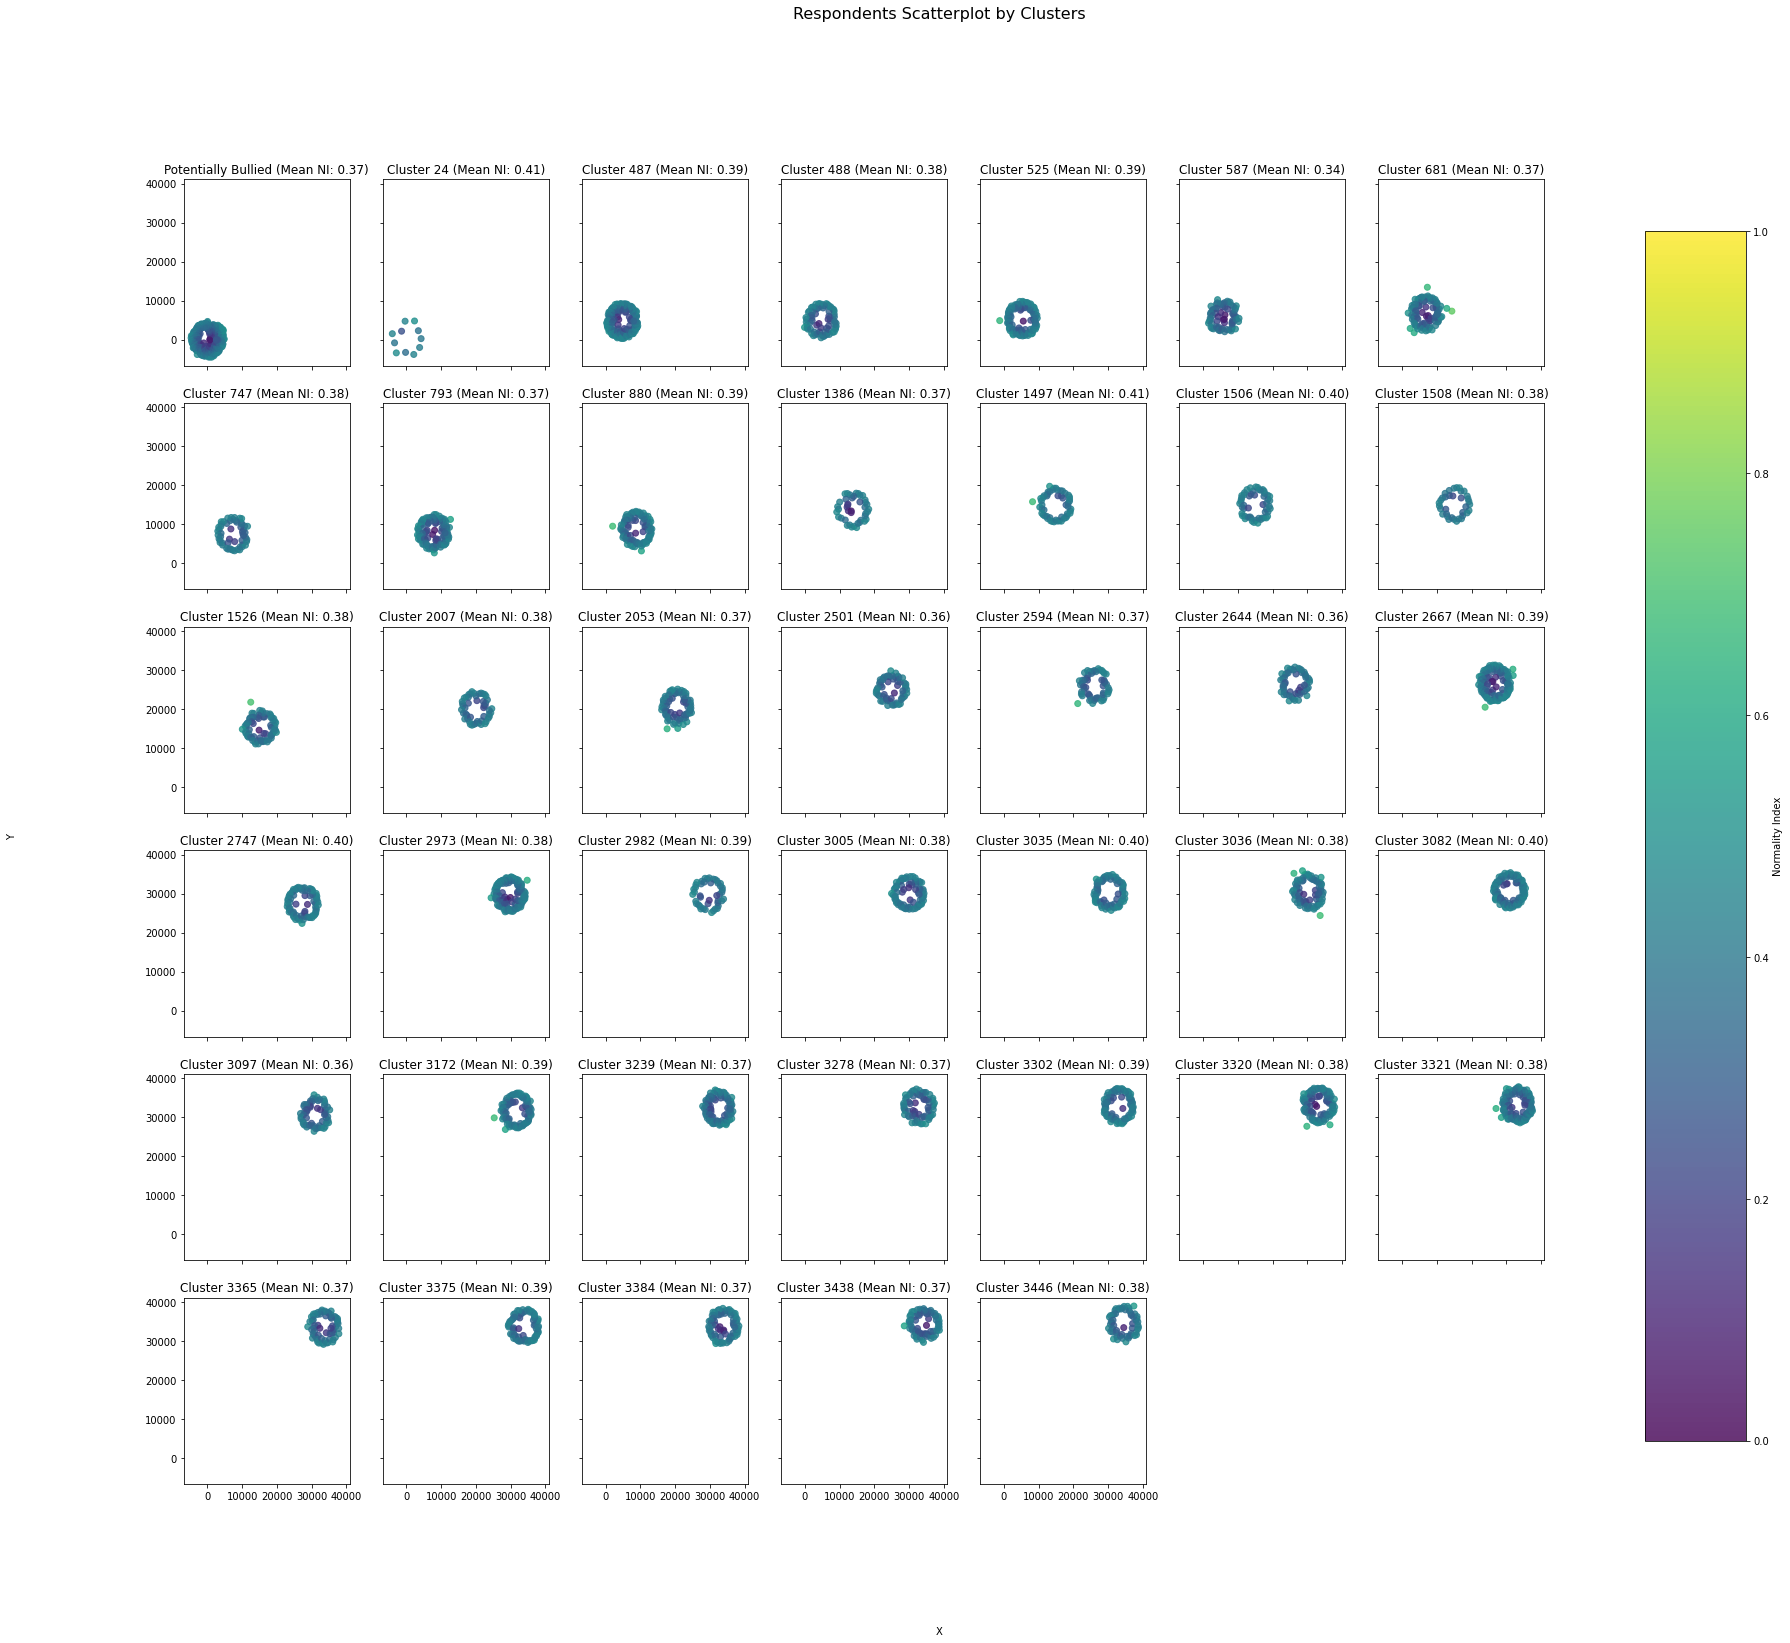

In [13]:

# Create a new cluster for small clusters
respondents_df['cluster'] = respondents_df['louvainCommunity']
small_clusters = respondents_df['louvainCommunity'].value_counts().loc[lambda x: x <= 10].index
respondents_df.loc[respondents_df['louvainCommunity'].isin(small_clusters), 'cluster'] = -1

# Calculate the mean normality index for each cluster
cluster_means = respondents_df.groupby('cluster')['normalityIndex'].mean()

# Create a layout with unique centroids
layout_df = create_layout(respondents_df, 'cluster', 'x', 'y')

# Create subplots
clusters = sorted(layout_df['cluster'].unique())
n_clusters = len(clusters)
ncols = int(np.ceil(np.sqrt(n_clusters)))
nrows = int(np.ceil(n_clusters / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), sharex=True, sharey=True)
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(0, 1)

# Function to plot a cluster in a subplot
def plot_cluster(ax, data, title, cmap, norm):
    sc = ax.scatter(data['x'], data['y'], c=data['normalityIndex'], cmap=cmap, norm=norm, alpha=0.8)
    ax.set_title(title)
    return sc

# Plot the clusters in the subplots
for ax, cluster in zip(axes.flatten(), clusters):
    cluster_data = layout_df[layout_df['cluster'] == cluster]
    mean_ni = cluster_means.loc[cluster]
    title = f"Potentially Bullied (Mean NI: {mean_ni:.2f})" if cluster == -1 else f"Cluster {cluster} (Mean NI: {mean_ni:.2f})"
    sc = plot_cluster(ax, cluster_data, title, cmap, norm)

# Remove unused subplots
for ax in axes.flatten()[len(clusters):]:
    ax.remove()

# Add colorbar to the side of the entire plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='Normality Index')

# Set common labels
fig.text(0.5, 0.04, 'X', ha='center', va='center')
fig.text(0.04, 0.5, 'Y', ha='center', va='center', rotation='vertical')
fig.suptitle("Respondents Scatterplot by Clusters", fontsize=16)
plt.show()



Percentage of respondents without clusters: 13.32%


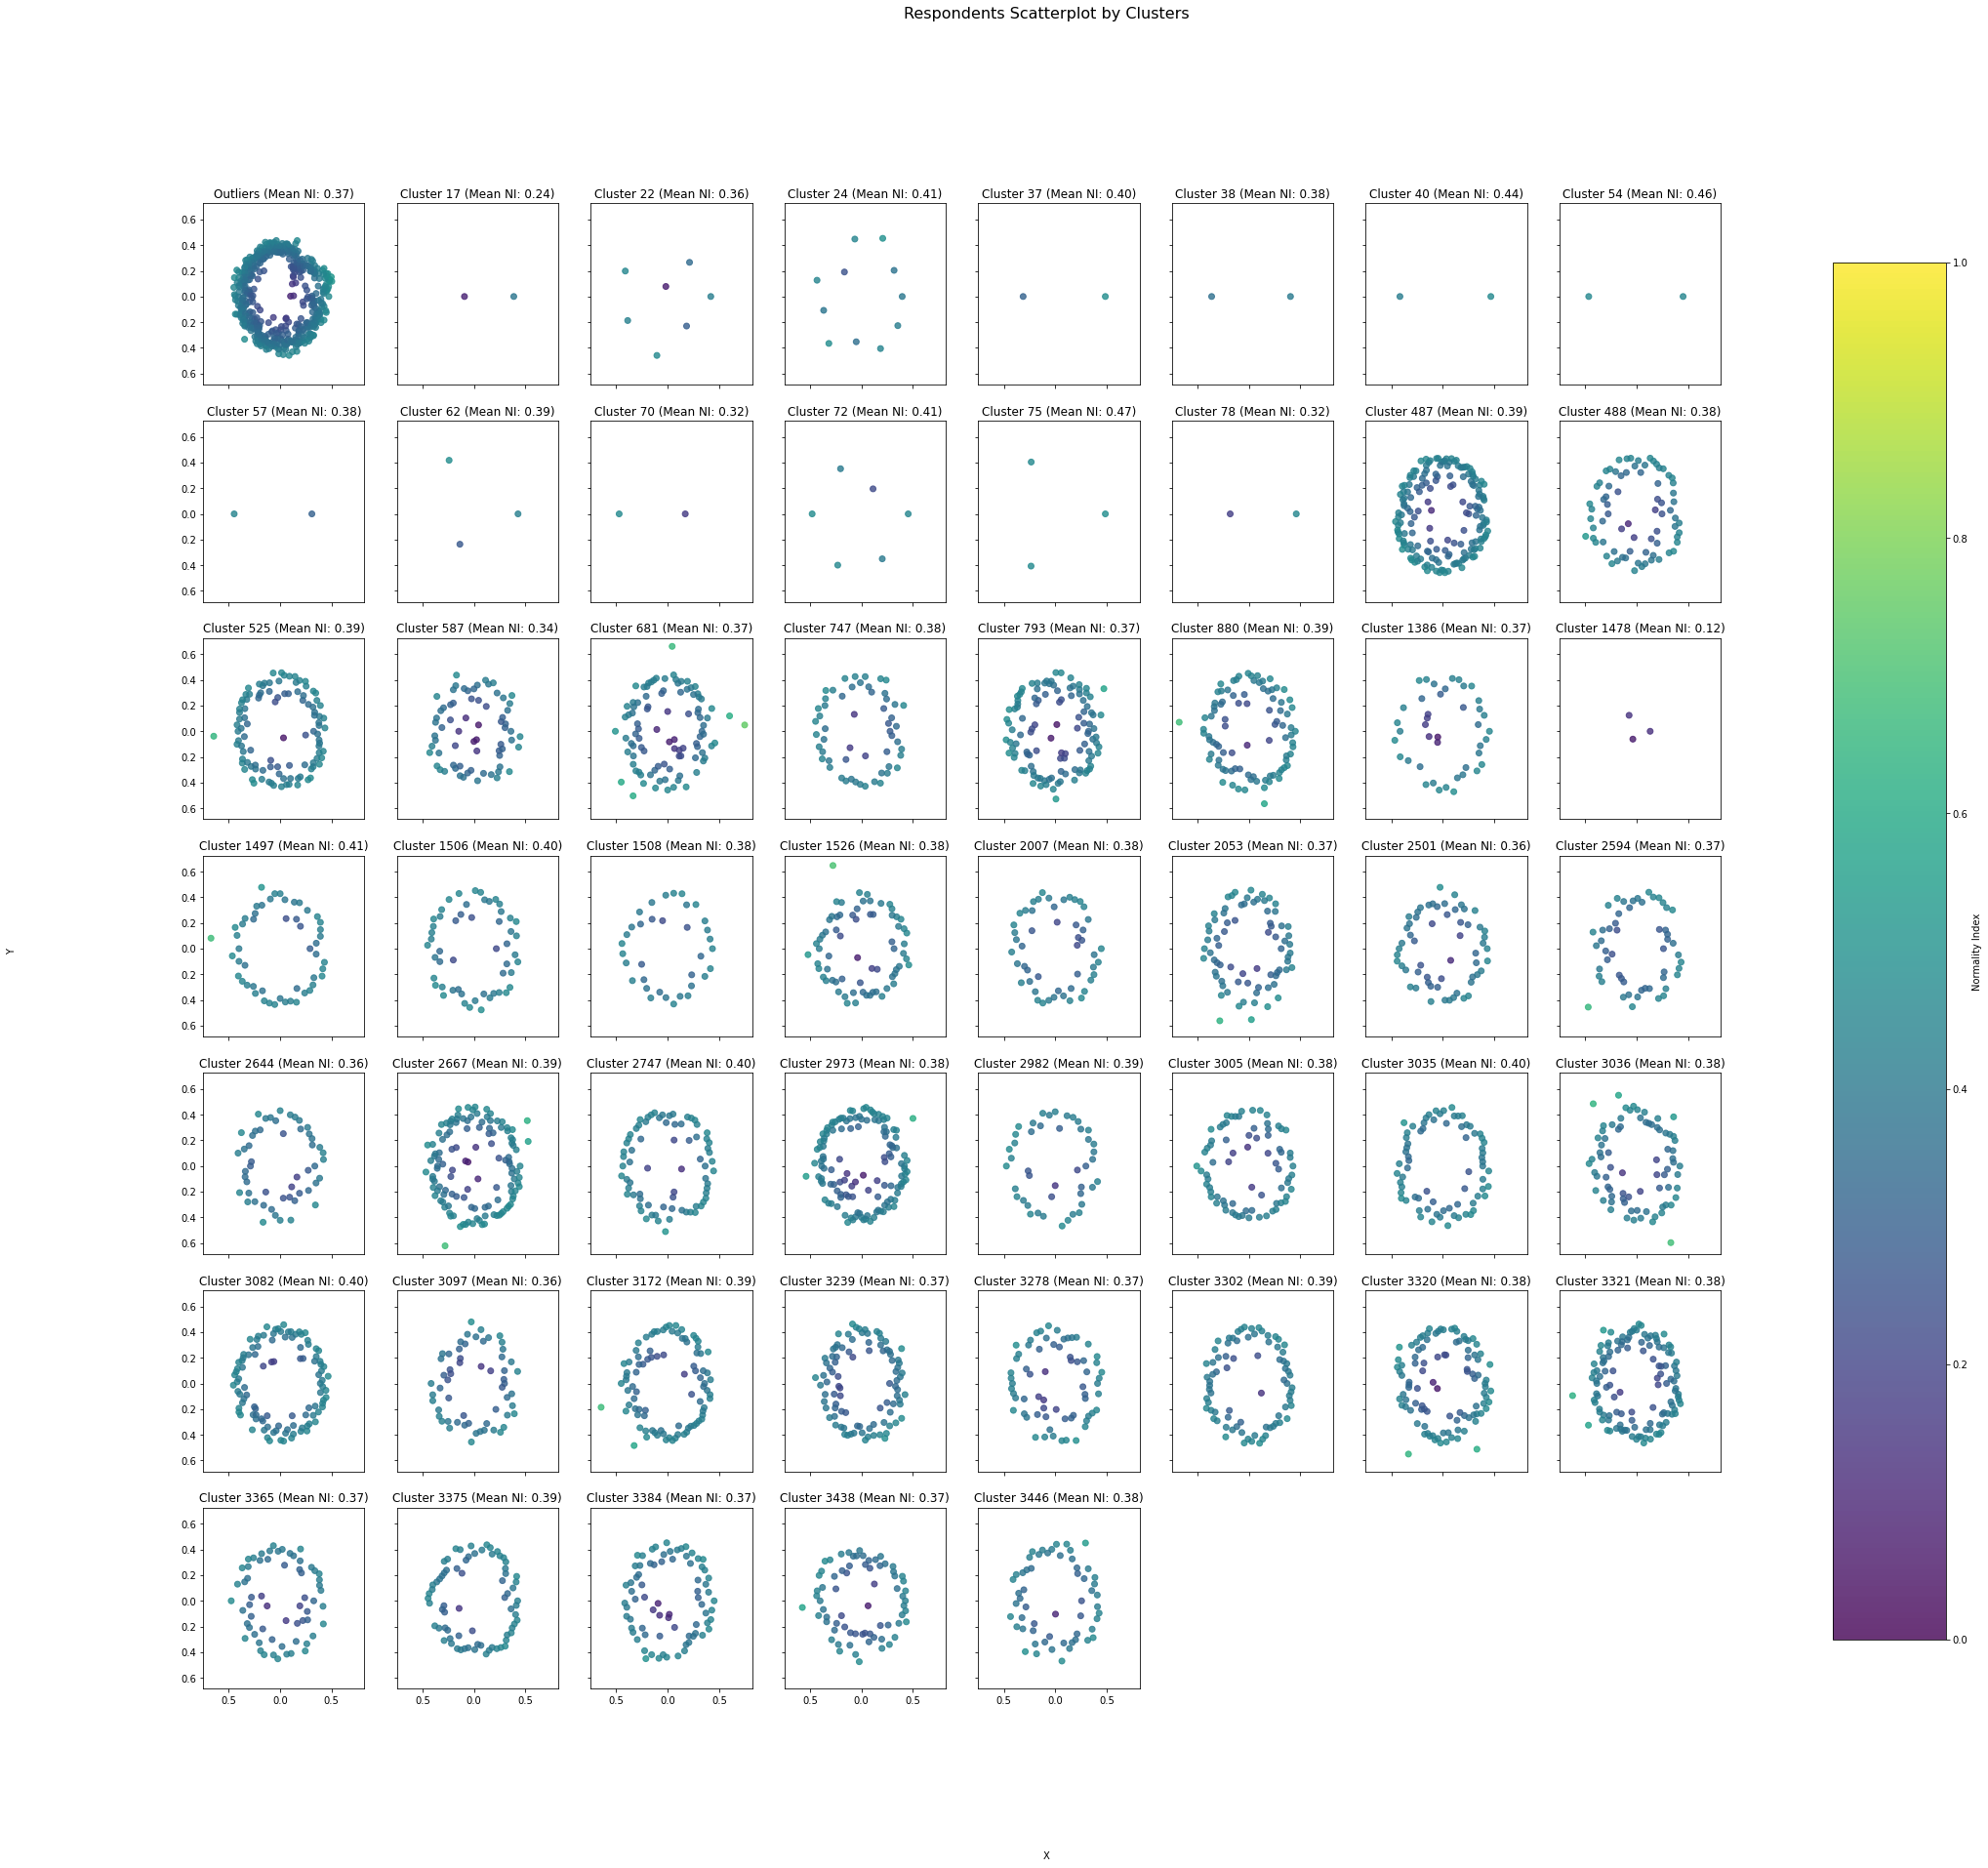

In [14]:
import matplotlib.ticker as ticker

# Function to generate a layout without unique centroids
def create_layout(df, cluster_col, x_col, y_col):
    layout_df = df.copy()
    layout_df[x_col] = 0
    layout_df[y_col] = 0
    clusters = layout_df[cluster_col].unique()

    for cluster in clusters:
        cluster_data = layout_df[layout_df[cluster_col] == cluster]
        n = len(cluster_data)
        angles = np.linspace(0, 2 * np.pi, n + 1)[:-1]
        radii = cluster_data['normalityIndex']
        layout_df.loc[cluster_data.index, x_col] = radii * np.cos(angles)
        layout_df.loc[cluster_data.index, y_col] = radii * np.sin(angles)

    return layout_df


# Create a new cluster for small clusters
respondents_df['cluster'] = respondents_df['louvainCommunity']
small_clusters = respondents_df['louvainCommunity'].value_counts().loc[lambda x: x <= 1].index
respondents_df.loc[respondents_df['louvainCommunity'].isin(small_clusters), 'cluster'] = -1

# Calculate the mean normality index for each cluster
cluster_means = respondents_df.groupby('cluster')['normalityIndex'].mean()

# Create a layout with unique centroids
layout_df = create_layout(respondents_df, 'cluster', 'x', 'y')

# Create subplots
clusters = sorted(layout_df['cluster'].unique())
n_clusters = len(clusters)
ncols = int(np.ceil(np.sqrt(n_clusters)))
nrows = int(np.ceil(n_clusters / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4), sharex=True, sharey=True)
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(0, 1)

# Function to plot a cluster in a subplot
def plot_cluster(ax, data, title, cmap, norm):
    sc = ax.scatter(data['x'], data['y'], c=data['normalityIndex'], cmap=cmap, norm=norm, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{abs(x):.1f}"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f"{abs(y):.1f}"))
    return sc

# Plot the clusters in the subplots
for ax, cluster in zip(axes.flatten(), clusters):
    cluster_data = layout_df[layout_df['cluster'] == cluster]
    mean_ni = cluster_means.loc[cluster]
    title = f"Outliers (Mean NI: {mean_ni:.2f})" if cluster == -1 else f"Cluster {cluster} (Mean NI: {mean_ni:.2f})"
    sc = plot_cluster(ax, cluster_data, title, cmap, norm)

# Remove unused subplots
for ax in axes.flatten()[len(clusters):]:
    ax.remove()

# Save cluster data to an Excel file
with pd.ExcelWriter('results/clusters_data.xlsx') as writer:
    for cluster in clusters:
        cluster_data = respondents_df[respondents_df['cluster'] == cluster]
        cluster_data.to_excel(writer, sheet_name=f"Cluster {cluster if cluster != -1 else 'Outliers'}", index=False)

# Add colorbar to the side of the entire plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax, label='Normality Index')
print(f"Percentage of respondents without clusters: {len(layout_df[layout_df['cluster'] == -1]) / len(layout_df) * 100:.2f}%")
# Set common labels
fig.text(0.5, 0.04, 'X', ha='center', va='center')
fig.text(0.04, 0.5, 'Y', ha='center', va='center', rotation='vertical')
fig.suptitle("Respondents Scatterplot by Clusters", fontsize=16)
plt.show()


